# Consumer segmentation - choosing optimal cluster numbers for mixed variables

In this exercise, you will 
- use elbow chart to determine how many consumer segments to generate
- segment consumers using the optimal number of segments
- because the data have mixed data types, k-prototypes algorithm should be used
- Comparable to SSE for k-means, a "clustering cost" is used to measure the fitting error for k-prototype

We will use "MallCustomersAllVariables.csv" for analysis. Github link can be found [here](https://github.com/zoutianxin1992/MarketingAnalyticsPython/blob/main/Marketing%20Analytics%20in%20Python/Segmentation/Datasets/MallCustomersTwoVariables.csv).

## Load and preprocess data

In [6]:
# importing packages
import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes   # We will use the k-prototypes algorithm
from matplotlib import pyplot as plt

# change variable names
url = "https://raw.githubusercontent.com/zoutianxin1992/MarketingAnalyticsPython/main/Marketing%20Analytics%20in%20Python/Segmentation/Datasets/MallCustomersAllVariables.csv"
df = pd.read_csv(url,index_col=0) # use the first column (customer id) as index
df = df.rename(columns = {"Gender":"gender",
                         "Age":"age",
                         "Annual Income (k$)":"annual_income",
                         "Spending Score (1-100)":"spending_score"})

# normalizing the data for k-mean algorithm
df_normalized = df.copy() # create a copy of the orignial dataset



df_normalized[['age','annual_income','spending_score']] = \
    (df[['age','annual_income','spending_score']]-df[['age','annual_income','spending_score']].min()) \
    /(df[['age','annual_income','spending_score']].max()-df[['age','annual_income','spending_score']].min())

# "\" breaks a line into multiple lines. There shouldn't be any spaces after "\"
df_normalized.head()

,gender,age,annual_income,spending_score
CustomerID,,,,
1,M,0.057692,0.000000,0.816327
2,M,0.019231,0.000000,0.387755
3,F,0.096154,0.008197,0.775510
4,F,0.038462,0.008197,0.051020
5,F,0.076923,0.016393,0.765306


## Determine the optimal number of segments

In [12]:
# calculate clustering cost (comparable to SSE) for different k's, and store them in a vector
# you should use a for loop

K = 10  # K is the maximum number of clusters we will check
store_cost = np.zeros(K-1)    # create a vector to store the clustering "cost", which is comparable to SSE in k-means. k is between 2 and K. 

for k in range(2, K+1):                                   # try k from 2 to K  
    kprotoSpec = KPrototypes(n_clusters = k, n_init = 20)                        # set up k-mean model with k clusters
    kproto_result = kprotoSpec.fit(df_normalized, categorical = [0])               # run k-mean on normalized data
    kproto_prediction = kproto_result.labels_                 # the predicted segments for consumers  
    store_cost[k-2] = kproto_result.cost_         # store the clustering cost 

store_cost

array([33.8075906 , 27.48659686, 22.5363837 , 18.74497062, 15.8817905 ,
       14.21778195, 12.22352406, 11.15544178, 10.24971722])

Text(0.5,0,'number of clusters')

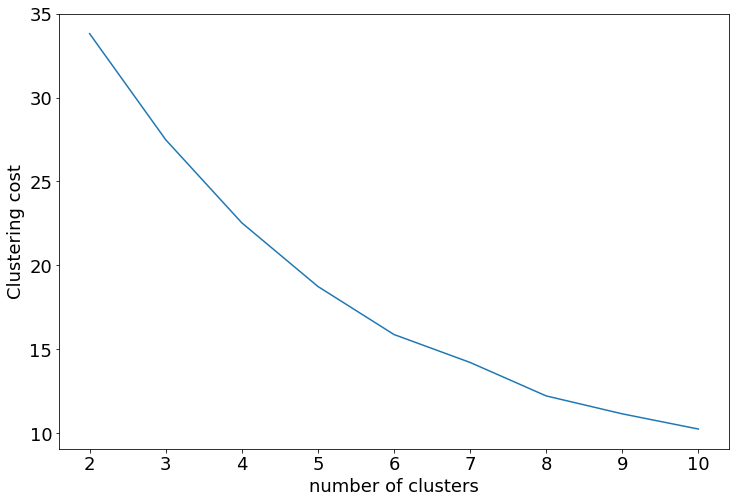

In [13]:
# plot elbow chart

%matplotlib inline
plt.rcParams['figure.figsize'] = [12,8]  # set figure size to be 12*8 inch
plt.plot(range(2, K+1), store_cost)        
plt.xticks(range(2, K+1), fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("Clustering cost",fontsize = 18)
plt.xlabel("number of clusters", fontsize = 18)

## Segment consumers using the optimal number of segments

In [14]:
kprotoSpec = KPrototypes(n_clusters = 6, n_init = 20)  # setup the k-mean model specs
kproto_result = kprotoSpec.fit(df_normalized,categorical = [0])    # apply the above model to the normalized data and store the result

## Post-segmentation analysis

### Which segment does each consumer belong to?

Create a new column in the **original** dataframe for which segment a consumer belongs to.

In [15]:
df["segment"] = kproto_result.labels_ 
df.head()

,gender,age,annual_income,spending_score,segment
CustomerID,,,,,
1,M,21,15,81,1
2,M,19,15,39,1
3,F,23,16,77,2
4,F,20,16,6,2
5,F,22,17,76,2


For each segment, summarize the mean/min/max's of all the variable.
Also count the number of consumers in each segment.

In [16]:
# summarize numerical variables
summary_numerical = df.groupby("segment").aggregate({                           # groupby("X") enables the calculation is separately done for each value of X 
    "age":["mean","min","max"],
    "annual_income": ["mean","min","max"],             # calculate the mean/min/max/std of annual income for each segment
    "spending_score": ["mean","min","max"],            # calculate the mean/min/max/std of spending score for each segment
    "segment": "count"                                       # count how many consumers are there in each segment
}
)
summary_numerical

age         annual_income          spending_score          \
              mean min max          mean min  max           mean min max   
segment                                                                    
0        50.148936  35  68     54.319149  18  101      37.553191   5  59   
1        28.162162  18  40     54.486486  15  101      67.945946  35  97   
2        25.945946  18  35     42.216216  16   76      57.459459   6  99   
3        58.037037  37  70     47.629630  19   71      38.851852   3  60   
4        32.269231  27  38     90.346154  70  137      82.730769  69  97   
5        38.653846  19  59     90.230769  71  137      16.730769   1  36   

        segment  
          count  
segment          
0            47  
1            37  
2            37  
3            27  
4            26  
5            26

In [17]:
# summarize categorical variables (gender)

summary_categorical = (df.groupby("segment"))["gender"].value_counts(normalize = True)
summary_categorical

segment  gender
0        F         1.000000
1        M         1.000000
2        F         1.000000
3        M         1.000000
4        F         0.807692
         M         0.192308
5        M         0.730769
         F         0.269231
Name: gender, dtype: float64